# Modelling and Strategy Development
The following represents an example of a trading strategy development by implementing a primary and a meta-model, triple-barrier labeling and random-forest classification. The data used are E-mini S&P 500 dollar bars created from tick data.

- Reference: Advances in Financial Machine Learning, Marcos Lopez De Prado (2018)

In [0]:
!pip install mlfinlab

In [0]:
!pip install pyfolio

In [0]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.dates as mdates
import matplotlib.font_manager as font_manager
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import pyfolio as pf

from pandas_datareader import data as pdr

from statsmodels.graphics.tsaplots import plot_acf

from numpy import array
from numpy import argmax

from sklearn.utils import resample
from sklearn.utils import shuffle
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split

from sklearn.metrics import roc_curve, auc
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV

from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer

from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

from mlfinlab.filters import filters
from mlfinlab.labeling import labeling
from mlfinlab.util import utils

from mlfinlab.sampling import concurrent
from mlfinlab.sampling import bootstrapping
from mlfinlab.util import multiprocess

% matplotlib inline

/usr/local/lib/python3.6/dist-packages/pyfolio/pos.py:28: UserWarning: Module "zipline.assets" not found; mutltipliers will not be applied to position notionals.
  ' to position notionals.'


In [0]:
# enabling reading Google Drive files from within notebooks (you need to do this only once per session)
from google.colab import drive
drive.mount('/content/drive')

In [0]:
# loading data
r = pd.read_csv('/content/drive/My Drive/Colab Notebooks/financial-data-structures-master/saved_data/dollar_bars_2015_2016.csv')
r.index = pd.to_datetime(r['date_time'])
r = r.drop('date_time', axis=1)
prices = r["close"]

###############################################################################
# Features 1: Technical indicators
###############################################################################

def moving_average(x, n, type='simple'):
    """
    computeing an n period moving average.
    type is 'simple' | 'exponential'
    """
    x = np.asarray(x)
    if type == 'exponential':
        weights = np.ones(n)
    else:
        weights = np.exp(np.linspace(-1., 0., n))

    weights /= weights.sum()

    a = np.convolve(x, weights, mode='full')[:len(x)]
    a[:n] = a[n]
    return a


def relative_strength(prices, n=14):
    """
    computing the n period relative strength indicator
    http://stockcharts.com/school/doku.php?id=chart_school:glossary_r#relativestrengthindex
    http://www.investopedia.com/terms/r/rsi.asp
    """

    deltas = np.diff(prices)
    seed = deltas[:n + 1]
    up = seed[seed >= 0].sum() / n
    down = -seed[seed < 0].sum() / n
    rs = up / down
    rsi = np.zeros_like(prices)
    rsi[:n] = 100. - 100. / (1. + rs)

    for i in range(n, len(prices)):
        delta = deltas[i - 1]  # because the diff is 1 shorter!

        if delta > 0:
            upval = delta
            downval = 0.
        else:
            upval = 0.
            downval = -delta

        up = (up * (n - 1) + upval) / n
        down = (down * (n - 1) + downval) / n

        rs = up / down
        rsi[i] = 100. - 100. / (1. + rs)
    return rsi


def moving_average_convergence(x, nslow, nfast):
    """
    computing the MACD (Moving Average Convergence/Divergence) using a fast and
    slow exponential moving avg
    return value is emaslow, emafast, macd which are len(x) arrays
    """
    emaslow = moving_average(x, nslow, type='exponential')
    emafast = moving_average(x, nfast, type='exponential')
    return emaslow, emafast, emafast - emaslow


def bbands(close_prices, window, no_of_stdev):
    #rolling_mean = close_prices.rolling(window=window).mean()
    #rolling_std = close_prices.rolling(window=window).std()
    rolling_mean = close_prices.ewm(span=window).mean()
    rolling_std = close_prices.ewm(span=window).std()

    upper_band = rolling_mean + (rolling_std * no_of_stdev)
    lower_band = rolling_mean - (rolling_std * no_of_stdev)

    return rolling_mean, upper_band, lower_band

# computing RSI
r['rsi'] = relative_strength(r['close'], 14)

# computing BB
r['BBmid'], r['BBup'], r['BBlo'] = bbands(r['close'], 50, no_of_stdev=1.5)

# computing the MACD indicator
nslow = 48
nfast = 26
nema = 20
emaslow, emafast, macd = moving_average_convergence(prices, nslow=nslow, nfast=nfast)
r['MACD'] = macd
r['MACD_sig'] = moving_average(r['MACD'], nema, type='exponential')

# computing the MAs
ma20 = moving_average(prices, 20, type='simple')
ma60 = moving_average(prices, 100, type='exponential')
ma200 = moving_average(prices, 200, type='simple')

In [0]:
###############################################################################
# Signalling
###############################################################################

#### DIRECTION
r['dir'] = 0 
short_dir = (ma60 <= ma200) 
long_dir = (ma60 > ma200) 
r.loc[long_dir, 'dir'] = 1
r.loc[short_dir, 'dir'] = -1

#### OVERSOLD/OVERBOUGHT
r['over'] = 0 
oversold = (r['rsi'] <= 30) 
overbought = (r['rsi'] >= 70) 
r.loc[overbought, 'over'] = 1
r.loc[oversold, 'over'] = -1

#### MACD MOMENTUM
r['MACD_mom'] = 0 
down = (r['MACD'] <= r['MACD_sig']) 
up = (r['MACD'] > r['MACD_sig']) 
r.loc[up, 'MACD_mom'] = 1
r.loc[down, 'MACD_mom'] = -1

##### SIDES
r['sides'] = np.nan 
long_signals = (r['close'] <= r['BBlo']) 
short_signals = (r['close'] >= r['BBup']) 
r.loc[long_signals, 'sides'] = 1
r.loc[short_signals, 'sides'] = -1

# Remove Look ahead bias by lagging the signal
r['dir'] = r['dir'].shift(1)
r['over'] = r['over'].shift(1)
r['MACD_mom'] = r['MACD_mom'].shift(1)
r['sides'] = r['sides'].shift(1)

In [0]:
print("MA Direction:")
print(r.dir.value_counts())
print("\n Oversold/overbought:")
print(r.over.value_counts())
print("\n MACD momentum:")
print(r.MACD_mom.value_counts())
print("\n BB Sides:")
print(r.sides.value_counts())

In [0]:
# Restore dataframe (skip this cell during first run)
r = r_bck.copy()

In [0]:
# Creating a separate set for TB labelling
data = r.copy()
data.dropna(axis=0, how='any', inplace=True)

In [0]:
###############################################################################
# Triple Barrier Labeling
###############################################################################
# computing daily volatility
daily_vol = utils.get_daily_vol(close=data['close'], lookback=50)

# applying Symmetric CUSUM Filter and getting timestamps for events given the daily volatility
cusum_events = filters.cusum_filter(data['close'], threshold = daily_vol['2011-09-01':'2018-01-01'].mean() * 0.04)

# compute vertical barrier
vertical_barriers = labeling.add_vertical_barrier(t_events = cusum_events, close=data['close'], num_days=1)

pt_sl = [1, 2]
min_ret = 0.0005 
triple_barrier_events = labeling.get_events(close=data['close'],
                                            t_events=cusum_events,
                                            pt_sl=pt_sl,
                                            target=daily_vol,
                                            min_ret=min_ret,
                                            num_threads=2,
                                            vertical_barrier_times=vertical_barriers,
                                            side_prediction=data['sides'])                # Here we choose one of the signals for the primary model 
# labeling
labels = labeling.get_bins(triple_barrier_events, data['close'])
labels.side.value_counts()

/usr/local/lib/python3.6/dist-packages/mlfinlab/labeling/labeling.py:124: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  target = target.loc[t_events]
2019-10-16 17:19:07.727708 100.0% apply_pt_sl_on_t1 done after 0.06 minutes. Remaining 0.0 minutes.


 1.0    1005
-1.0     815
Name: side, dtype: int64

In [0]:
###############################################################################
# Primary Model Forecast
###############################################################################
primary_forecast = pd.DataFrame(labels['bin'])
primary_forecast['pred'] = 1
primary_forecast.columns = ['actual', 'pred']

# Performance Metrics
actual = primary_forecast['actual']
pred = primary_forecast['pred']
print(classification_report(y_true=actual, y_pred=pred))

print("Confusion Matrix")
print(confusion_matrix(actual, pred))

print('')
print("Accuracy")
print(accuracy_score(actual, pred))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00      1376
           1       0.24      1.00      0.39       444

    accuracy                           0.24      1820
   macro avg       0.12      0.50      0.20      1820
weighted avg       0.06      0.24      0.10      1820

Confusion Matrix
[[   0 1376]
 [   0  444]]

Accuracy
0.24395604395604395


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [0]:
###############################################################################
# Features 2: More features
###############################################################################
# Log Returns
r['log_ret'] = np.log(r['close']).diff()

# Momentum
r['mom1'] = r['close'].pct_change(periods=1)
r['mom2'] = r['close'].pct_change(periods=2)
r['mom3'] = r['close'].pct_change(periods=3)
r['mom4'] = r['close'].pct_change(periods=4)
r['mom5'] = r['close'].pct_change(periods=5)

# Log -t returns
r['log_t1'] = r['log_ret'].shift(1)
r['log_t2'] = r['log_ret'].shift(2)
r['log_t3'] = r['log_ret'].shift(3)
r['log_t4'] = r['log_ret'].shift(4)
r['log_t5'] = r['log_ret'].shift(5)


# Volatility
window_stdev = 50
r['vol_50'] = r['log_ret'].rolling(window=window_stdev, min_periods=50, center=False).std()
#r['vol_13'] = r['log_ret'].rolling(window=window_stdev, min_periods=13, center=False).std()
#r['vol_7'] = r['log_ret'].rolling(window=window_stdev, min_periods=7, center=False).std()

# Serial Correlation
window_autocorr = 50
r['autocorr_1'] = r['log_ret'].rolling(window=window_autocorr, min_periods=window_autocorr, center=False).apply(lambda x: x.autocorr(lag=1), raw=False)
r['autocorr_2'] = r['log_ret'].rolling(window=window_autocorr, min_periods=window_autocorr, center=False).apply(lambda x: x.autocorr(lag=2), raw=False)
r['autocorr_3'] = r['log_ret'].rolling(window=window_autocorr, min_periods=window_autocorr, center=False).apply(lambda x: x.autocorr(lag=3), raw=False)
r['autocorr_4'] = r['log_ret'].rolling(window=window_autocorr, min_periods=window_autocorr, center=False).apply(lambda x: x.autocorr(lag=4), raw=False)
r['autocorr_5'] = r['log_ret'].rolling(window=window_autocorr, min_periods=window_autocorr, center=False).apply(lambda x: x.autocorr(lag=5), raw=False)

# Backup full features dataframe
r_bck = r.copy()

In [0]:
###############################################################################
# Preparing Features Data
###############################################################################
X = r.loc[labels.index, :]
# dropping unwanted columns
X.drop(['BBmid', 'BBup','BBlo','open', #'over', 'dir', 'sides', 
        #'MACD_mom', 
        'high', 'low', 'close', 'log_ret', 'cum_vol', 'cum_dollar', 'cum_ticks', 
        'MACD', 'rsi', 
        'mom2','mom3', 'mom4','mom5', 
        #'vol_13', 'vol_7', 'log_t2', 'log_t3', 'log_t4', 'log_t5',
        'MACD_sig'], axis=1, inplace=True)
y = labels['bin']
y.value_counts()

0    1376
1     444
Name: bin, dtype: int64

In [0]:
###############################################################################
# In-Sample training and testing
###############################################################################
# splitting data into training and validation (test) sets
X_training_validation = X['2015-01-01':'2016-03-01']
y_training_validation = y['2015-01-01':'2016-03-01']
X_train, X_test, y_train, y_test = train_test_split(X_training_validation, y_training_validation, test_size=0.2, shuffle=False)
train_df = pd.concat([y_train, X_train], axis=1, join='inner')

# Upsample the training data to have a 50 - 50 split
# https://elitedatascience.com/imbalanced-classes
majority = train_df[train_df['bin'] == 0]
minority = train_df[train_df['bin'] == 1]

new_minority = resample(minority, 
                   replace=True,     # sample with replacement
                   n_samples=majority.shape[0],    # to match majority class
                   random_state=42)

train_df = pd.concat([majority, new_minority])
train_df = shuffle(train_df, random_state=42)

train_df['bin'].value_counts()

# Creating training data
X_train = train_df.loc[:, train_df.columns != 'bin']
y_train = train_df['bin']

In [0]:
###############################################################################
# Principal Component Analysis
###############################################################################
def preprocessing_transformation(X_train,X_test):
    #imputer = preprocessing.Imputer() # deprecated, using SimpleImputer instead
    imputer = SimpleImputer() 
    scaler = preprocessing.MinMaxScaler()
    X_train_trans = imputer.fit_transform(X_train)
    X_train_trans = scaler.fit_transform(X_train)
    X_test_trans = imputer.fit_transform(X_test)
    X_test_trans = scaler.fit_transform(X_test)
    return X_train_trans, X_test_trans

# preprocessing
X_train_pre_trans, X_test_pre_trans = preprocessing_transformation(X_train,X_test)
X_train_pre_trans, X_test_pre_trans = np.nan_to_num(X_train_pre_trans),np.nan_to_num(X_train_pre_trans)

In [0]:
def pca_transformation(X_train,X_test,explained_ratio_thresh=0.02):
    pca = PCA()
    pca.fit(X_train)
    n_components = (pca.explained_variance_ratio_>explained_ratio_thresh).sum()
    X_train_trans = pca.transform(X_train)[:,:n_components]
    X_test_trans = pca.transform(X_test)[:,:n_components]
    return X_train_trans, X_test_trans

# transforming
X_train_pca_trans, X_test_pca_trans = pca_transformation(X_train_pre_trans, X_test_pre_trans)

# plotting
plt.figure(figsize=(20,9))
plt.subplot(1,2,1)
plt.title("Raw data correlation")
sns.heatmap(pd.DataFrame(X_train, columns = X_train.columns).corr(),annot=True)

plt.subplot(1,2,2)
plt.title("Post-PCA Transformation corellation")
sns.heatmap(pd.DataFrame(X_train_pca_trans).corr(),annot=True)
plt.tight_layout()

In [0]:
###############################################################################
# Meta Model Fitting
###############################################################################
# Finding best parameters for the random forest model
parameters = {'max_depth':[2,3,4],
              'n_estimators':[100, 500, 1000, 5000, 10000],
              'random_state':[50]}
    
def perform_grid_search(X_data, y_data):
    rf = RandomForestClassifier(criterion='entropy')
    clf = GridSearchCV(rf, parameters, cv=4, scoring='roc_auc', n_jobs=3) 
    clf.fit(np.nan_to_num(X_train), np.nan_to_num(y_train))
    print(clf.cv_results_['mean_test_score'])
    return clf.best_params_['n_estimators'], clf.best_params_['max_depth'], clf.best_params_['random_state']

# extracting parameters
n_estimator, depth, c_random_state = perform_grid_search(np.nan_to_num(X_train), np.nan_to_num(y_train))


In [0]:
depth = 7
n_estimator = 512
c_random_state = 42

In [0]:
# Random forest model training, to decide whether to trade or not (i.e 1 or 0 respectively) since the earlier model has decided the side (-1 or 1)
rf = RandomForestClassifier(max_depth=depth, n_estimators=n_estimator, #class_weight='balanced_subsample',
                            criterion='entropy', random_state=c_random_state)
rf.fit(np.nan_to_num(X_train), np.nan_to_num(y_train))

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
                       max_depth=7, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=512,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

              precision    recall  f1-score   support

           0       0.98      0.93      0.95       681
           1       0.93      0.98      0.96       681

    accuracy                           0.95      1362
   macro avg       0.96      0.95      0.95      1362
weighted avg       0.96      0.95      0.95      1362

Confusion Matrix
[[630  51]
 [ 11 670]]

Accuracy
0.9544787077826725


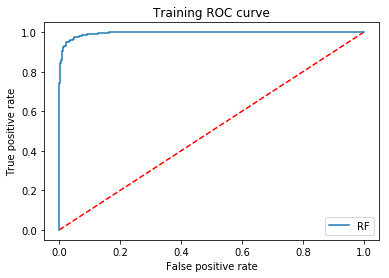

In [0]:
###############################################################################
# Training Metrics
###############################################################################

y_pred_rf = rf.predict_proba(np.nan_to_num(X_train))[:, 1]
y_pred = rf.predict(np.nan_to_num(X_train))

fpr_rf, tpr_rf, _ = roc_curve(y_train, y_pred_rf)
print(classification_report(y_train, y_pred))

print("Confusion Matrix")
print(confusion_matrix(y_train, y_pred))

print('')
print("Accuracy")
print(accuracy_score(y_train, y_pred))

plt.figure(1)
plt.plot([0, 1], [0, 1], 'r--')
plt.plot(fpr_rf, tpr_rf, label='RF')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('Training ROC curve')
plt.legend(loc='best')
plt.show()

              precision    recall  f1-score   support

           0       0.75      0.74      0.75       161
           1       0.34      0.36      0.35        61

    accuracy                           0.64       222
   macro avg       0.55      0.55      0.55       222
weighted avg       0.64      0.64      0.64       222

Confusion Matrix
[[119  42]
 [ 39  22]]

Accuracy
0.6351351351351351


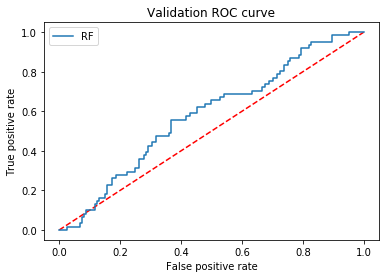

In [0]:
###############################################################################
# Validation Metrics
############################################################################### 

y_pred_rf = rf.predict_proba(np.nan_to_num(X_test))[:, 1]
y_pred = rf.predict(np.nan_to_num(X_test))

fpr_rf, tpr_rf, _ = roc_curve(y_test, y_pred_rf)
print(classification_report(y_test, y_pred))

print("Confusion Matrix")
print(confusion_matrix(y_test, y_pred))

print('')
print("Accuracy")
print(accuracy_score(y_test, y_pred))

plt.figure(1)
plt.plot([0, 1], [0, 1], 'r--')
plt.plot(fpr_rf, tpr_rf, label='RF')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('Validation ROC curve')
plt.legend(loc='best')
plt.show()

In [0]:
# Primary model on validation time-span
primary_forecast = pd.DataFrame(labels['bin'])
primary_forecast['pred'] = 1
primary_forecast.columns = ['actual', 'pred']

start = primary_forecast.index.get_loc(X_test.index.min())
end = primary_forecast.index.get_loc(X_test.index.max()) + 1

subset_prim = primary_forecast[start:end]

# Performance Metrics
actual = subset_prim['actual']
pred = subset_prim['pred']
print(classification_report(y_true=actual, y_pred=pred))

print("Confusion Matrix")
print(confusion_matrix(actual, pred))

print('')
print("Accuracy")
print(accuracy_score(actual, pred))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       161
           1       0.27      1.00      0.43        61

    accuracy                           0.27       222
   macro avg       0.14      0.50      0.22       222
weighted avg       0.08      0.27      0.12       222

Confusion Matrix
[[  0 161]
 [  0  61]]

Accuracy
0.2747747747747748


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [0]:
###############################################################################
# Feature Importance
###############################################################################
title = 'Feature Importance:'
figsize = (15, 5)

feat_imp = pd.DataFrame({'Importance':rf.feature_importances_})    
feat_imp['feature'] = X.columns
feat_imp.sort_values(by='Importance', ascending=False, inplace=True)
feat_imp = feat_imp

feat_imp.sort_values(by='Importance', inplace=True)
feat_imp = feat_imp.set_index('feature', drop=True)
feat_imp.plot.barh(title=title, figsize=figsize)
plt.xlabel('Feature Importance Score')

plt.show()

In [0]:
###############################################################################
# In-Sample Trading Performance
###############################################################################
# Without meta-labeling
def get_daily_returns(intraday_returns):
    """
    This changes returns into daily returns that will work using pyfolio. Its not perfect...
    """
    
    cum_rets = ((intraday_returns + 1).cumprod())

    # Downsample to daily
    daily_rets = cum_rets.resample('B').last()

    # Forward fill, Percent Change, Drop NaN
    daily_rets = daily_rets.ffill().pct_change().dropna()
    
    return daily_rets

valid_dates = X_test.index

pf.show_perf_stats(labels.loc[valid_dates, 'ret'])

Start date,2016-01-06
End date,2016-03-01
Total months,10
,Backtest
Annual return,194.0%
Cumulative returns,158.5%
Annual volatility,24.2%
Sharpe ratio,4.58
Calmar ratio,6.04
Stability,0.88
Max drawdown,-32.1%


In [0]:
# With meta-labeling

pf.show_perf_stats(labels.loc[valid_dates, 'ret'] * y_pred)

Start date,2016-01-06
End date,2016-03-01
Total months,10
,Backtest
Annual return,46.8%
Cumulative returns,40.2%
Annual volatility,13.4%
Sharpe ratio,2.92
Calmar ratio,2.89
Stability,0.90
Max drawdown,-16.2%


In [0]:
###############################################################################
# Out-of-Sample Testing
###############################################################################
# Extracting out-of-sample data (forward-test)
X_forward = X['2016-03-02':]
y_forward = y['2016-03-02':]

              precision    recall  f1-score   support

           0       0.77      0.93      0.84       534
           1       0.42      0.16      0.24       176

    accuracy                           0.74       710
   macro avg       0.60      0.54      0.54       710
weighted avg       0.68      0.74      0.69       710

Confusion Matrix
[[494  40]
 [147  29]]

Accuracy
0.7366197183098592


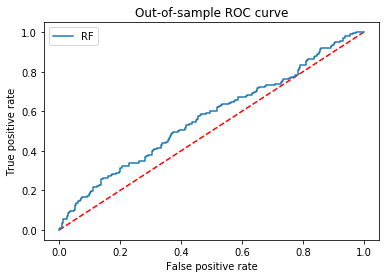

In [0]:
# Performance Metrics
y_pred_rf = rf.predict_proba(np.nan_to_num(X_forward))[:, 1]
y_pred = rf.predict(np.nan_to_num(X_forward))
fpr_rf, tpr_rf, _ = roc_curve(np.nan_to_num(y_forward), y_pred_rf)
print(classification_report(np.nan_to_num(y_forward), y_pred))

print("Confusion Matrix")
print(confusion_matrix(y_forward, y_pred))

print('')
print("Accuracy")
print(accuracy_score(y_forward, y_pred))

plt.figure(1)
plt.plot([0, 1], [0, 1], 'r--')
plt.plot(fpr_rf, tpr_rf, label='RF')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('Out-of-sample ROC curve')
plt.legend(loc='best')
plt.show()

In [0]:
# Primary model out-of-sample
primary_forecast = pd.DataFrame(labels['bin'])
primary_forecast['pred'] = 1
primary_forecast.columns = ['actual', 'pred']

subset_prim = primary_forecast['2016-03-02':]

# Performance Metrics
actual = subset_prim['actual']
pred = subset_prim['pred']
print(classification_report(y_true=actual, y_pred=pred))

print("Confusion Matrix")
print(confusion_matrix(actual, pred))

print('')
print("Accuracy")
print(accuracy_score(actual, pred))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       534
           1       0.25      1.00      0.40       176

    accuracy                           0.25       710
   macro avg       0.12      0.50      0.20       710
weighted avg       0.06      0.25      0.10       710

Confusion Matrix
[[  0 534]
 [  0 176]]

Accuracy
0.24788732394366197


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Start date,2016-03-07
End date,2016-12-28
Total months,10
,Backtest
Annual return,389.4%
Cumulative returns,282.8%
Annual volatility,105.3%
Sharpe ratio,1.93
Calmar ratio,12.55
Stability,0.76
Max drawdown,-31.0%


/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:56: FutureWarning: 
The current behaviour of 'Series.argmin' is deprecated, use 'idxmin'
instead.
The behavior of 'argmin' will be corrected to return the positional
minimum in the future. For now, use 'series.values.argmin' or
'np.argmin(np.array(values))' to get the position of the minimum
row.
  return getattr(obj, method)(*args, **kwds)


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,31.04,2016-06-23,2016-07-08,2016-10-04,74
1,23.60,2016-11-14,2016-12-13,NaT,NaN
2,20.31,2016-10-31,2016-11-07,2016-11-09,8
3,15.61,2016-05-19,2016-05-24,2016-06-23,26
4,9.18,2016-03-10,2016-03-17,2016-04-01,17


/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:56: FutureWarning: 
The current behaviour of 'Series.argmin' is deprecated, use 'idxmin'
instead.
The behavior of 'argmin' will be corrected to return the positional
minimum in the future. For now, use 'series.values.argmin' or
'np.argmin(np.array(values))' to get the position of the minimum
row.
  return getattr(obj, method)(*args, **kwds)


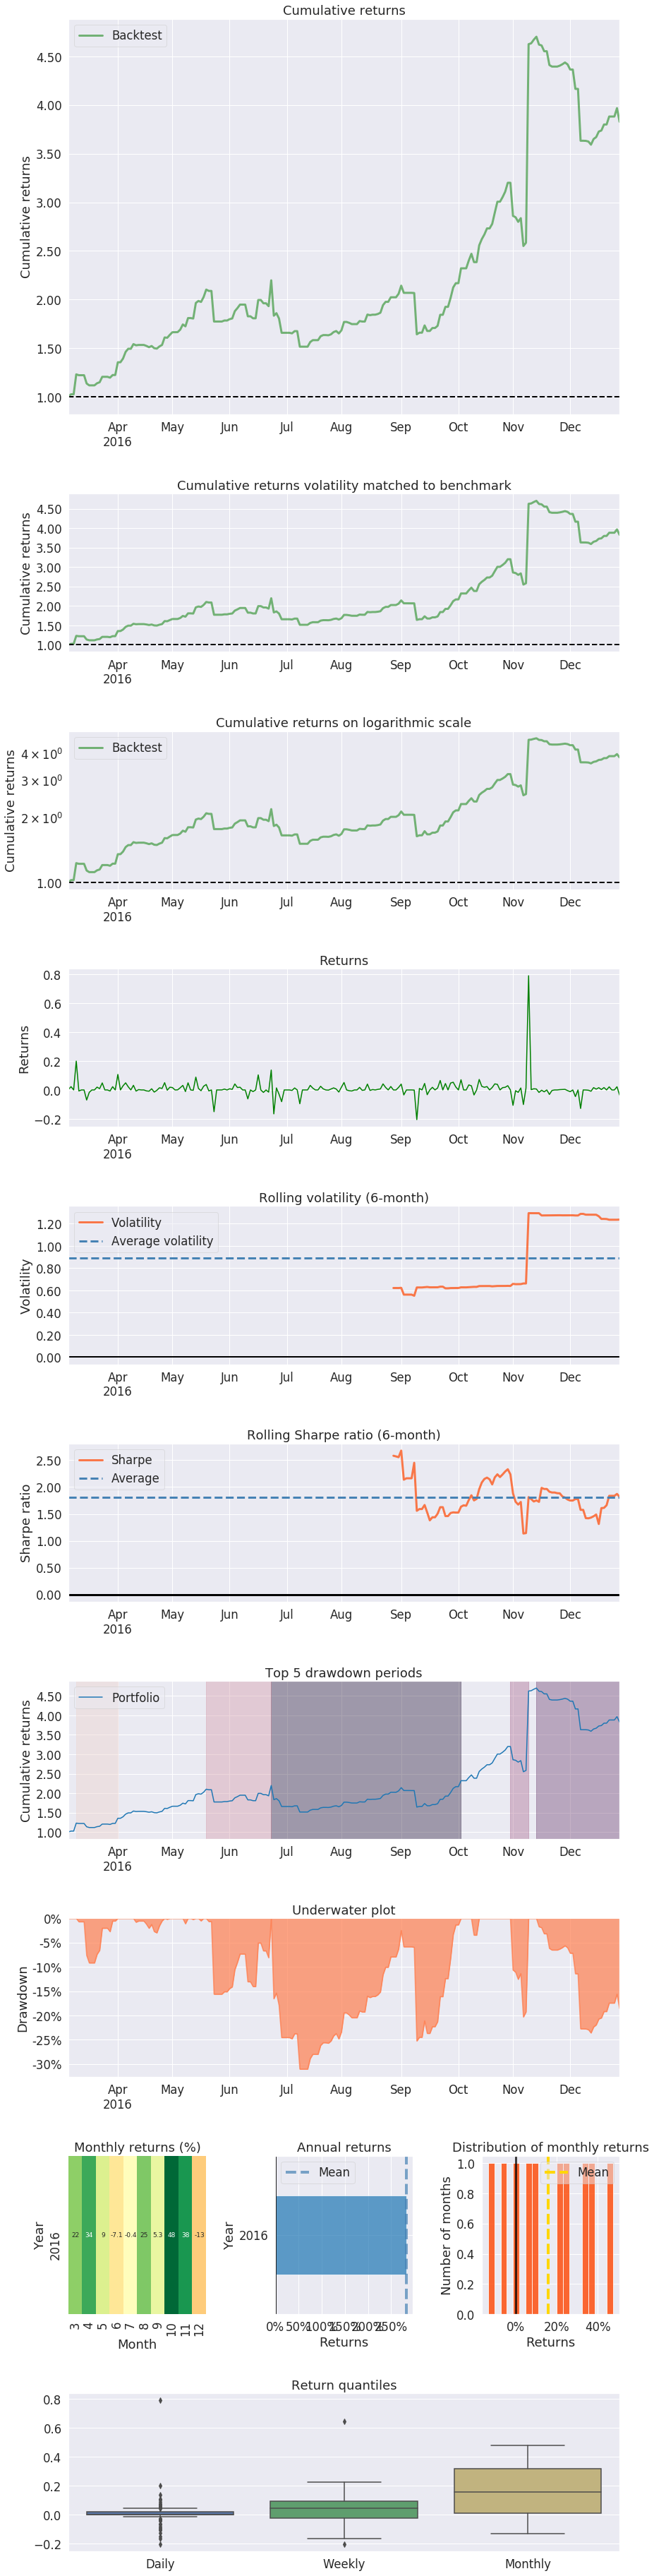

In [0]:
###############################################################################
# Out-of-Sample Trading Performance
###############################################################################
# Without meta-labeling

fwd_test_dates = X_forward.index

# Downsample to daily
prim_rets_test = labels.loc[fwd_test_dates, 'ret']
daily_rets_prim = get_daily_returns(prim_rets_test)

#pf.show_perf_stats(daily_rets_prim)
# pf.show_perf_stats(labels.loc[fwd_test_dates, 'ret'])
pf.create_returns_tear_sheet(daily_rets_prim, benchmark_rets=None)

Start date,2016-03-07
End date,2016-12-28
Total months,10
,Backtest
Annual return,41.5%
Cumulative returns,34.1%
Annual volatility,14.1%
Sharpe ratio,2.54
Calmar ratio,9.70
Stability,0.87
Max drawdown,-4.3%


/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:56: FutureWarning: 
The current behaviour of 'Series.argmin' is deprecated, use 'idxmin'
instead.
The behavior of 'argmin' will be corrected to return the positional
minimum in the future. For now, use 'series.values.argmin' or
'np.argmin(np.array(values))' to get the position of the minimum
row.
  return getattr(obj, method)(*args, **kwds)


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,4.28,2016-06-28,2016-06-29,2016-09-14,57
1,3.09,2016-04-11,2016-04-28,2016-05-05,19
2,1.32,2016-05-19,2016-06-20,2016-06-23,26
3,0.29,2016-10-26,2016-10-27,2016-10-28,3
4,0.00,2016-03-07,2016-03-07,2016-03-07,1


/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:56: FutureWarning: 
The current behaviour of 'Series.argmin' is deprecated, use 'idxmin'
instead.
The behavior of 'argmin' will be corrected to return the positional
minimum in the future. For now, use 'series.values.argmin' or
'np.argmin(np.array(values))' to get the position of the minimum
row.
  return getattr(obj, method)(*args, **kwds)


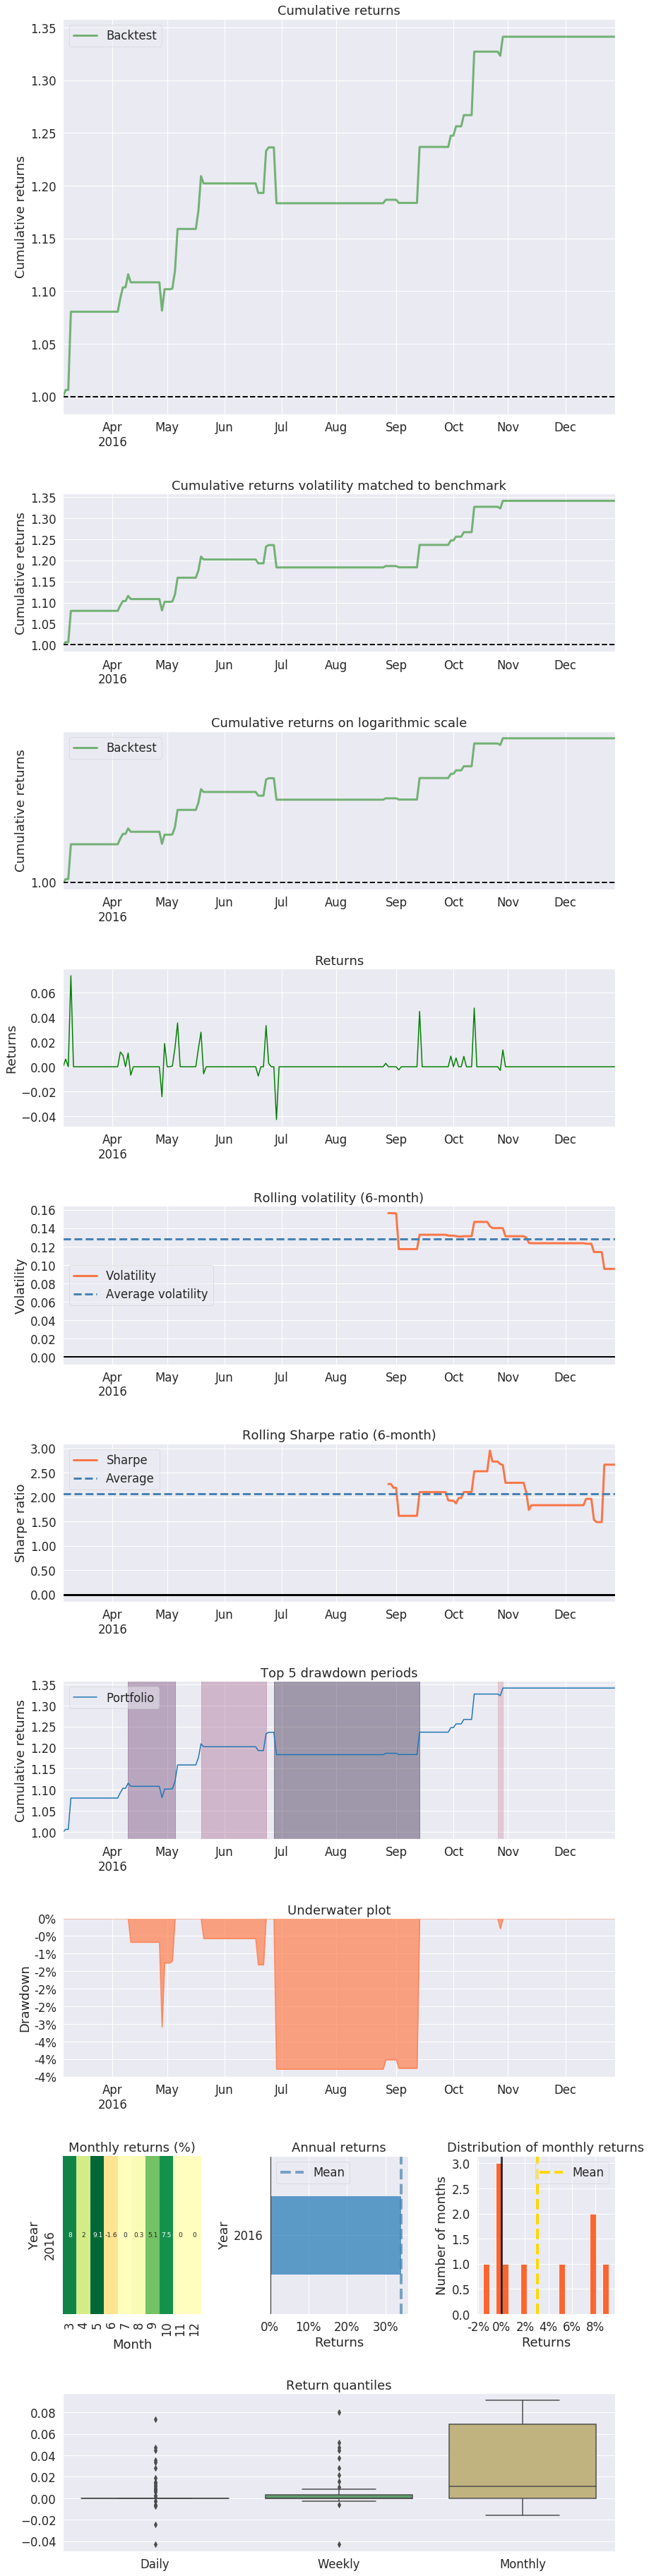

In [0]:
# With meta-labeling

meta_returns = labels.loc[fwd_test_dates, 'ret'] * y_pred
daily_rets_meta = get_daily_returns(meta_returns)

pf.create_returns_tear_sheet(daily_rets_meta, benchmark_rets=None)

In [0]:
###############################################################################
# Cross-Validation
###############################################################################
from sklearn.model_selection._split import _BaseKFold
from sklearn.model_selection import StratifiedKFold
from scipy import interp

class PurgedKFold(_BaseKFold):
    """
    Extend KFold class to work with labels that span intervals
    The train is purged of observations overlapping test-label intervals
    Test set is assumed contiguous (shuffle=False), w/o training samples in between
    """
    def __init__(self,n_splits=3,t1=None,pctEmbargo=0.):
        if not isinstance(t1,pd.Series):
            raise ValueError('Label Through Dates must be a pd.Series')
        super(PurgedKFold,self).__init__(n_splits,shuffle=False,random_state=None)
        self.t1=t1
        self.pctEmbargo=pctEmbargo
        
    def split(self,X,y=None,groups=None):
        if (X.index==self.t1.index).sum()!=len(self.t1):
            raise ValueError('X and ThruDateValues must have the same index')
        indices=np.arange(X.shape[0])
        mbrg=int(X.shape[0]*self.pctEmbargo)
        test_starts=[
            (i[0],i[-1]+1) for i in np.array_split(np.arange(X.shape[0]), self.n_splits)
        ]
        for i,j in test_starts:
            t0=self.t1.index[i] # start of test set
            test_indices=indices[i:j]
            maxT1Idx=self.t1.index.searchsorted(self.t1[test_indices].max())
            train_indices=self.t1.index.searchsorted(self.t1[self.t1<=t0].index)
            if maxT1Idx<X.shape[0]: # right train ( with embargo)
                train_indices=np.concatenate((train_indices, indices[maxT1Idx+mbrg:]))
            yield train_indices,test_indices
def crossValPlot(skf,classifier,X_,y_):
    
    X = np.nan_to_num(np.asarray(X_))
    y = np.nan_to_num(np.asarray(y_))
    
    tprs = []
    aucs = []
    mean_fpr = np.linspace(0, 1, 100)
    
    f,ax = plt.subplots(figsize=(10,7))
    i = 0
    for train, test in skf.split(X, y):
        probas_ = classifier.fit(X[train], y[train]).predict_proba(X[test])
        # Compute ROC curve and area the curve
        fpr, tpr, thresholds = roc_curve(y[test], probas_[:, 1])
        tprs.append(interp(mean_fpr, fpr, tpr))
        tprs[-1][0] = 0.0
        roc_auc = auc(fpr, tpr)
        aucs.append(roc_auc)
        ax.plot(fpr, tpr, lw=1, alpha=0.3,
                 label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))

        i += 1

    ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
             label='Luck', alpha=.8)

    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)
    ax.plot(mean_fpr, mean_tpr, color='b',
             label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
             lw=2, alpha=.8)

    std_tpr = np.std(tprs, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    ax.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                     label=r'$\pm$ 1 std. dev.')

    ax.set_xlim([-0.05, 1.05])
    ax.set_ylim([-0.05, 1.05])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title('Receiver operating characteristic')
    ax.legend(bbox_to_anchor=(1,1))

In [0]:
#Without shuffling
skf = StratifiedKFold(n_splits=10, shuffle=False, random_state=c_random_state)
classifier = RandomForestClassifier(n_estimators=n_estimator, max_depth=depth, 
                                    criterion='entropy',
                                    class_weight='balanced_subsample',
                                    random_state=c_random_state)
crossValPlot(skf,classifier,X,y)

In [0]:
#With shuffling
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=c_random_state)
classifier = RandomForestClassifier(n_estimators=n_estimator, max_depth=depth, 
                                    criterion='entropy',
                                    class_weight='balanced_subsample',
                                    random_state=c_random_state)
crossValPlot(skf,classifier,X,y)